In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights

import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
imsize = 512 if torch.cuda.is_available() else 128 

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.ToTensor()])  


def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)


style_img = image_loader("picasso.jpg")
content_img = image_loader("dancing.jpg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

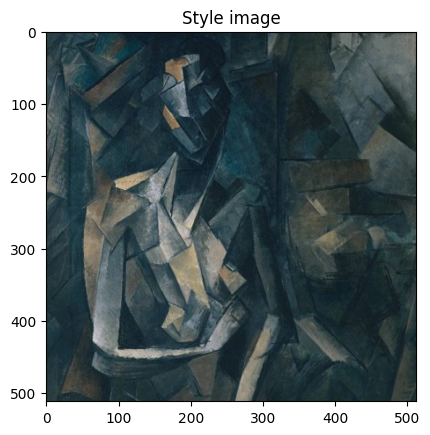

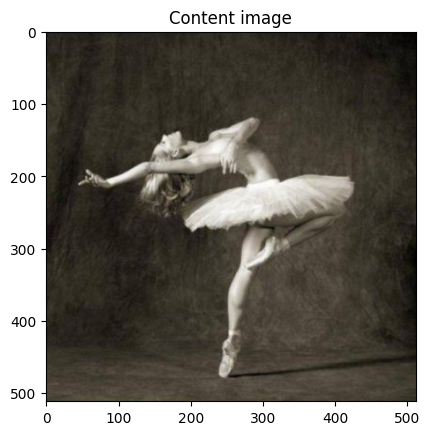

In [4]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor,title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

plt.figure()
imshow(style_img,title = "Style image")

plt.figure()
imshow(content_img,title = "Content image")

In [5]:
class ContentLoss(nn.Module):
    def __init__(self,target):
        super(ContentLoss,self).__init__()
        self.target = target.detach()
    def forward(self,input):
        self.loss = F.mse_loss(input,self.target)
        return input

In [6]:
def gram_matrix(input):
    a,b,c,d = input.size()
    features = input.view(a*b,c*d)
    
    G = torch.mm(features,features.t())
    
    return G.div(a*b*c*d)

In [7]:
class StyleLoss(nn.Module):
    def __init__(self,target_feature):
        super(StyleLoss,self).__init__()
        self.target = gram_matrix(target_feature).detach()
    def forward(self,input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G,self.target)
        return input

In [8]:
cnn = vgg19(weights = VGG19_Weights.DEFAULT).features.eval()

In [10]:
cnn_normalization_mean = torch.tensor([0.485,0.456,0.406])
cnn_normalization_std = torch.tensor([0.229,0.224,0.225])

class Normalization(nn.Module):
    def __init__(self,mean,std):
        super(Normalization,self).__init__()
        
        self.mean = torch.tensor(mean).view(-1,1,1)
        self.std = torch.tensor(std).view(-1,1,1)
    def forward(self,img):
        return (img - self.mean)/self.std

In [11]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1','conv_2','conv_3','conv_4','conv_5']

def get_style_model_and_losses(cnn,normalization_mean,normalization_std,
                               style_img,content_img,
                               content_layers = content_layers_default,
                               style_layers = style_layers_default):
    cnn = copy.deepcopy(cnn)
    
    normalization = Normalization(normalization_mean,normalization_std).to(device)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer,nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer,nn.ReLU):
            name = 'relu_{}'.format(i)
            layer = nn.ReLU(inplace = False)
        elif isinstance(layer,nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer,nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))
        
        model.add_module(name,layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i),content_loss)
            content_losses.append(content_loss)
        
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i),style_loss)
            style_losses.append(style_loss)
    
    for i in range(len(model)-1,-1,-1):
        if isinstance(model[i],ContentLoss) or isinstance(model[i],StyleLoss):
            break
    
    model = model[:(i+1)]
    
    return model,style_losses,content_losses

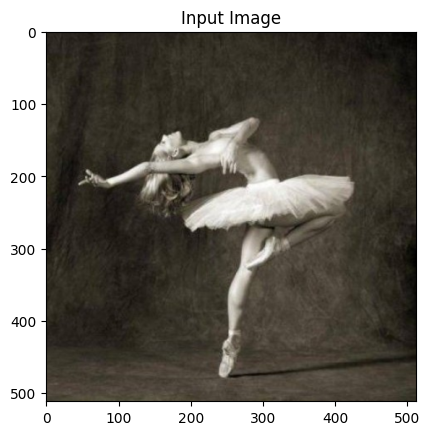

In [12]:
input_img = content_img.clone()
plt.figure()
imshow(input_img,title = "Input Image")

In [13]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [16]:
def run_style_transfer(cnn,normalization_mean,normalization_std,
                      content_img,style_img,input_img,num_steps = 300,
                      style_weight = 1000000,content_weight = 1):
    print("Building the style transfer model..")
    model,style_losses,content_losses = get_style_model_and_losses(cnn,normalization_mean,normalization_std,style_img,content_img)
    optimizer = get_input_optimizer(input_img)
    
    print("Optimizing..")
    
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            input_img.data.clamp_(0,1)
            
            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0
            
            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss
            
            style_score *= style_weight
            content_score *= content_weight
            
            loss = style_score + content_score
            loss.backward()
            
            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(style_score.item(),content_score.item()))
                print()
            
            return style_score + content_score
        
        optimizer.step(closure)
    
    input_img.data.clamp_(0,1)
    torch.save(model.state_dict(),'vgg_style_transfer.pth')
    
    return input_img

Building the style transfer model..
Optimizing..


/opt/conda/envs/pytorch/lib/python3.11/site-packages/torch/utils/_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


run [50]:
Style Loss : 0.233463 Content Loss: 2.306340

run [100]:
Style Loss : 0.218138 Content Loss: 2.278688

run [150]:
Style Loss : 0.200766 Content Loss: 2.259040

run [200]:
Style Loss : 0.180888 Content Loss: 2.246086

run [250]:
Style Loss : 0.164622 Content Loss: 2.236726

run [300]:
Style Loss : 0.152845 Content Loss: 2.230105



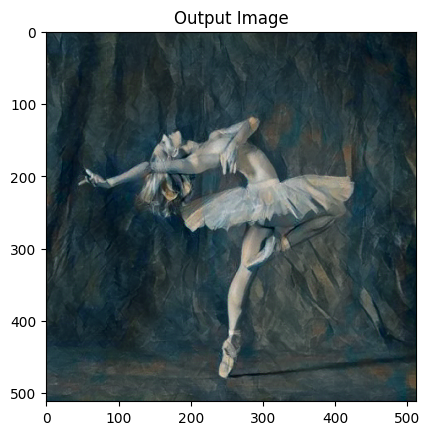

In [17]:
output = run_style_transfer(cnn,cnn_normalization_mean,cnn_normalization_std,content_img,style_img,input_img)

plt.figure()
imshow(output,title = "Output Image")

plt.ioff()
plt.show()